In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [2]:
import os

num_deleted = 0
for fold_name in ("Cat","Dog"):
    folder_path = os.path.join("PetImages",fold_name)
    for file_name in os.listdir(folder_path):
        full_path = os.path.join(folder_path,file_name)
        try:
            file_object = open(full_path,"rb")
            is_jfif = tf.compat.as_bytes("JFIF") in file_object.peek(10)
        finally:
            file_object.close()
        
        if not is_jfif:
            num_deleted += 1
            os.remove(full_path)

print("Deleted {} files".format(num_deleted))

Deleted 1578 files


In [3]:
image_size = (180, 180)
batch_size = 32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size)

value_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


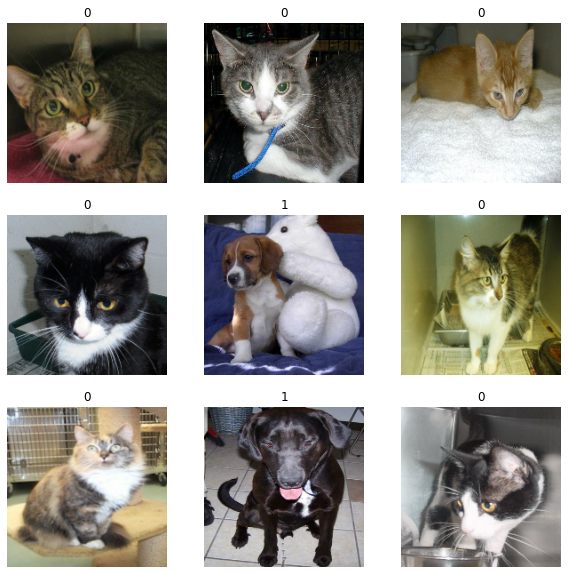

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        axis = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

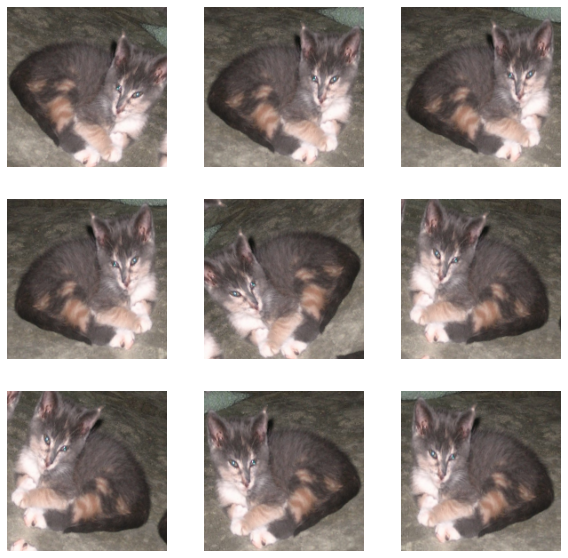

In [7]:
plt.figure(figsize=(10,10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
augmented_train_ds = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [11]:
train_dataset = train_dataset.prefetch(buffer_size=32)
value_dataset = value_dataset.prefetch(buffer_size=32)

In [14]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape= image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("Epoch/save_at_epoch_{epoch}.h5"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    train_dataset,epochs=epochs,callbacks=callbacks,validation_data=value_dataset)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 73/586 [==>...........................] - ETA: 31:13 - loss: 0.7297 - accuracy: 0.5839

Error: Canceled future for execute_request message before replies were done

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)